# Deep Fake Detection

## Importing Libraries

In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import plotly.figure_factory as ff
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris 
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhare\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhare\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
os.getcwd()

'C:\\Users\\dhare'

In [3]:
os.chdir("C:\\Users\\dhare\\Downloads\\dharel\dharel")

## Dataset Loading

In [4]:
# Load the data files
fake_news_path = 'fake_news.csv'
true_news_path = 'true_news.csv'

fake_news = pd.read_csv(fake_news_path, names=['text'])
true_news = pd.read_csv(true_news_path, names=['text'])


In [5]:
# Add labels
fake_news['label'] = 1  # 1 for fake
true_news['label'] = 0  # 0 for true



In [6]:
# Combine datasets
data = pd.concat([fake_news, true_news]).reset_index(drop=True)#original row index old indices are dropped not added


## Data Exploration

In [7]:
print("Data sample:")
print(data.sample(5))
print("\nData distribution:")
print(data['label'].value_counts())

Data sample:
                                                    text  label
35068  Reuters  Virginia Governor Terry McAuliffe on ...      0
40077  FRANKFURT Reuters  A Swiss man was handed a su...      0
16660                THE GREAT QUESTION OF CITIZENSHIP        1
45666  ROME Reuters  Pope Francis flew out of Italy o...      0
15230   I m leaving the GOP and running as a Democrat...      1

Data distribution:
label
1    23869
0    22311
Name: count, dtype: int64


In [8]:
data.head(5)

text  label
0                                               text      1
1  Donald Trump just couldn t wish all Americans ...      1
2  House Intelligence Committee Chairman Devin Nu...      1
3  On Friday it was revealed that former Milwauke...      1
4  On Christmas day Donald Trump announced that h...      1

In [9]:
# Check label distribution
label_counts = data['label'].value_counts()

# Plot label distribution
fig = px.bar(label_counts, x=label_counts.index, y=label_counts.values, 
             labels={'x': 'Label', 'y': 'Count'}, 
             title='Label Distribution')
fig.show()

## Data Cleaning

In [10]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\n', ' ', text)  # Remove newlines
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

data['clean_text'] = data['text'].apply(clean_text)



In [11]:
data = data.drop_duplicates(subset='text')

# Handle missing values
missing_values = data.isnull().sum()#calculate missing value 

# Drop rows with missing values
data = data.dropna()

## Text Preprocessing

In [12]:

def preprocess_text(text): # re(regular expression) is used to replace text
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    tokens = text.split()  # Tokenize using split
    stop_words = set(stopwords.words('english')) #remove the an in a etc  conver to set for fater porcessing
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords Keeps only words not in stopwords list
    return ' '.join(tokens) # then rejoins the filtered words back into a single string.


data['cleaned_text'] = data['text'].apply(preprocess_text)

#Reduces noise in text data
# Visualize text lengths yo thiyo
#word lai split garne ani count garne lamda
data['text_length'] = data['cleaned_text'].apply(lambda x: len(x.split()))#lamda is used so that we dont make function using def
fig = px.histogram(data, x='text_length', title='Distribution of Text Lengths')

fig.show()

## Feature Extraction

In [13]:
# Extract features using Bag of Words
vectorizer = CountVectorizer(max_features=5000)#limit to 5000 most used word kun word dherai use bhairacha
X = vectorizer.fit_transform(data['cleaned_text']).toarray()# Converts text to frequency matrix fit vectorizer to text data
y = data['label']
# Visualize top words
#create data frame of word frequencies plots 20 most frequent words
word_counts = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 
                             'count': X.sum(axis=0)})
fig = px.bar(word_counts.sort_values(by='count', ascending=False).head(20), 
             x='word', y='count', 
             title='Top 20 Words by Frequency')
fig.show()

## Label Distribution

In [14]:
# retrieves label column
y = data['label']

# Visualize label encoding Count Label Frequencies
label_distribution = y.value_counts()
#Shows proportion of 'Fake' vs 'True' labels
fig = px.pie(values=label_distribution.values, names=['Fake', 'True'], 
             title='Label Distribution (Fake vs True)')
fig.show()


In [15]:
# Cross Validation for each model toi prevent overfitting and provide robust performance
def perform_cross_validation(model, X, y, model_name, n_folds=5):
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y, cv=n_folds)
    print(f"\nCross-validation results for {model_name}:")
    print(f"Individual fold scores: {cv_scores}")
    #Average performance across folds
    print(f"Mean CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")#format to 3 decimal places calculates 2 standard deviations
    
    return cv_scores

## Train-Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualize data split
split_counts = [len(X_train), len(X_test)]
fig = px.bar(x=['Train Set', 'Test Set'], y=split_counts, 
             labels={'x': 'Dataset', 'y': 'Number of Samples'}, 
             title='Train-Test Split')
fig.show()

## Train the Logistic Regression Model

In [17]:
model = LogisticRegression( class_weight='balanced',
    C=0.1,  # Decrease C to increase regularization (default is 1.0) prevents overfitting
    max_iter=1000,#increase maximum iterations to prevent premature stopping
    random_state=42)
lr_cv_scores = perform_cross_validation(model, X, y, "Logistic Regression")



Cross-validation results for Logistic Regression:
Individual fold scores: [0.85973516 0.99276606 0.97743992 0.98773758 0.89012876]
Mean CV Score: 0.942 (+/- 0.111)


In [18]:
model.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   random_state=42)

In [19]:
y_pred_lr = model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

## Evaluate the Model

In [20]:
# Predictions
y_pred = model.predict(X_test) #Generate predictions on test data Classifies samples as Fake or True

# Accuracy Calculates overall model performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
report = classification_report(y_test, y_pred, target_names=['Fake', 'True'])
print(report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

fig = ff.create_annotated_heatmap(z=cm, x=['Fake', 'True'], y=['Fake', 'True'], 
                                  colorscale='Viridis', 
                                  showscale=True)
fig.update_layout(title='Confusion Matrix')
fig.show()

Accuracy: 0.98
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.98      4504
        True       0.97      0.99      0.98      3652

    accuracy                           0.98      8156
   macro avg       0.98      0.98      0.98      8156
weighted avg       0.98      0.98      0.98      8156



In [21]:
def calculate_roc_with_cv(model, X, y, cv=5):#Evaluate model's binary classification performance Receiver-operating characteristic curve
    from sklearn.model_selection import cross_val_predict
    # Get predictions using cross-validation
    y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
    fpr, tpr, _ = roc_curve(y, y_pred_proba[:, 1])#1 is for positive class
    auc_score = roc_auc_score(y, y_pred_proba[:, 1])
    return fpr, tpr, auc_score


In [22]:
# Calculate FPR, TPR, and AUC for Logistic Regression

lr_fpr, lr_tpr, lr_auc = calculate_roc_with_cv(model, X, y)


In [23]:
# Plot the ROC Curve
fig = go.Figure()
fig.add_trace(go.Scatter(x=lr_fpr, y=lr_tpr, mode='lines', name=f'Logistic Regression (AUC={lr_auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Chance', line=dict(dash='dash')))
fig.update_layout(
    title='ROC Curve: Logistic Regression',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    xaxis=dict(range=[0, 1]),
    yaxis=dict(range=[0, 1]),
    showlegend=True
)
fig.show()

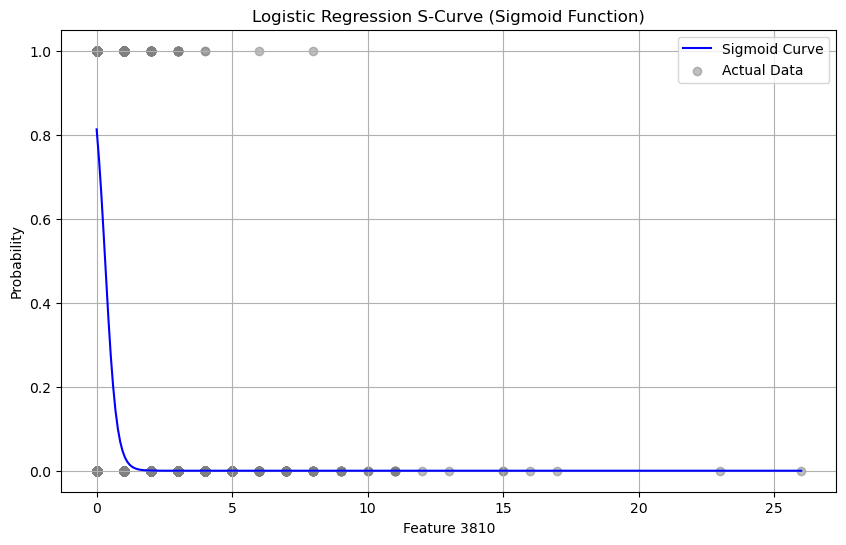

In [24]:
def plot_sigmoid_curve():
    # Get the most important feature for visualization
    feature_importance = abs(model.coef_[0])#model coefficient
    most_important_feature_idx = feature_importance.argmax()
    # Generate points for the S-curve
    #Extracts the values of the most important feature from the dataset X
    X_feature = X[:, most_important_feature_idx].reshape(-1, 1) 
    #creates 300 evenly spaced points
    X_plot = np.linspace(X_feature.min(), X_feature.max(), 300).reshape(-1, 1)
    
    # Create zero matrix for other features
    X_plot_full = np.zeros((X_plot.shape[0], X.shape[1]))
    X_plot_full[:, most_important_feature_idx] = X_plot.ravel()
    
    # Get probabilities
    #ensure smooth curve for visualization
    y_plot = model.predict_proba(X_plot_full)[:, 1]
    
    # Create the S-curve plot
    plt.figure(figsize=(10, 6))
    plt.plot(X_plot, y_plot, 'b-', label='Sigmoid Curve')
    plt.scatter(X_feature, y, c='gray', alpha=0.5, label='Actual Data')
    plt.xlabel(f'Feature {most_important_feature_idx}')
    plt.ylabel('Probability')
    plt.title('Logistic Regression S-Curve (Sigmoid Function)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the S-curve
plot_sigmoid_curve()

# Train Decision Tree Classifier Model

In [25]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [26]:
DTmodel =   DecisionTreeClassifier(
    max_depth=5, #reduces tree complexity to prevent 
    min_samples_split=10, #minimum number to spit node if node less than 10 no further split
    min_samples_leaf=5, # to ensure final leaf has 5 nodes
    random_state=10# to fix randomness
)
DT_cv_scores = perform_cross_validation(DTmodel, X, y, "Decision Tree Classifier")#94 is after averege 5 folds




Cross-validation results for Decision Tree Classifier:
Individual fold scores: [0.85814125 0.99656694 0.99350172 0.99411404 0.8974862 ]
Mean CV Score: 0.948 (+/- 0.117)


In [27]:
DTmodel.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=10)

In [28]:
pred_dt = DTmodel.predict(X_test)
DTmodel.score(X_test, y_test)

0.9780529671407553

In [29]:
y_pred_dt = DTmodel.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)

# Evaluate the model

In [30]:
# Predictions
y_pred = DTmodel.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
report = classification_report(y_test, y_pred, target_names=['Fake', 'True'])
print(report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig = ff.create_annotated_heatmap(z=cm, x=['Fake', 'True'], y=['Fake', 'True'], 
                                  colorscale='Viridis', 
                                  showscale=True)
fig.update_layout(title='Confusion Matrix')
fig.show()

Accuracy: 0.98
              precision    recall  f1-score   support

        Fake       0.98      0.98      0.98      4504
        True       0.98      0.98      0.98      3652

    accuracy                           0.98      8156
   macro avg       0.98      0.98      0.98      8156
weighted avg       0.98      0.98      0.98      8156



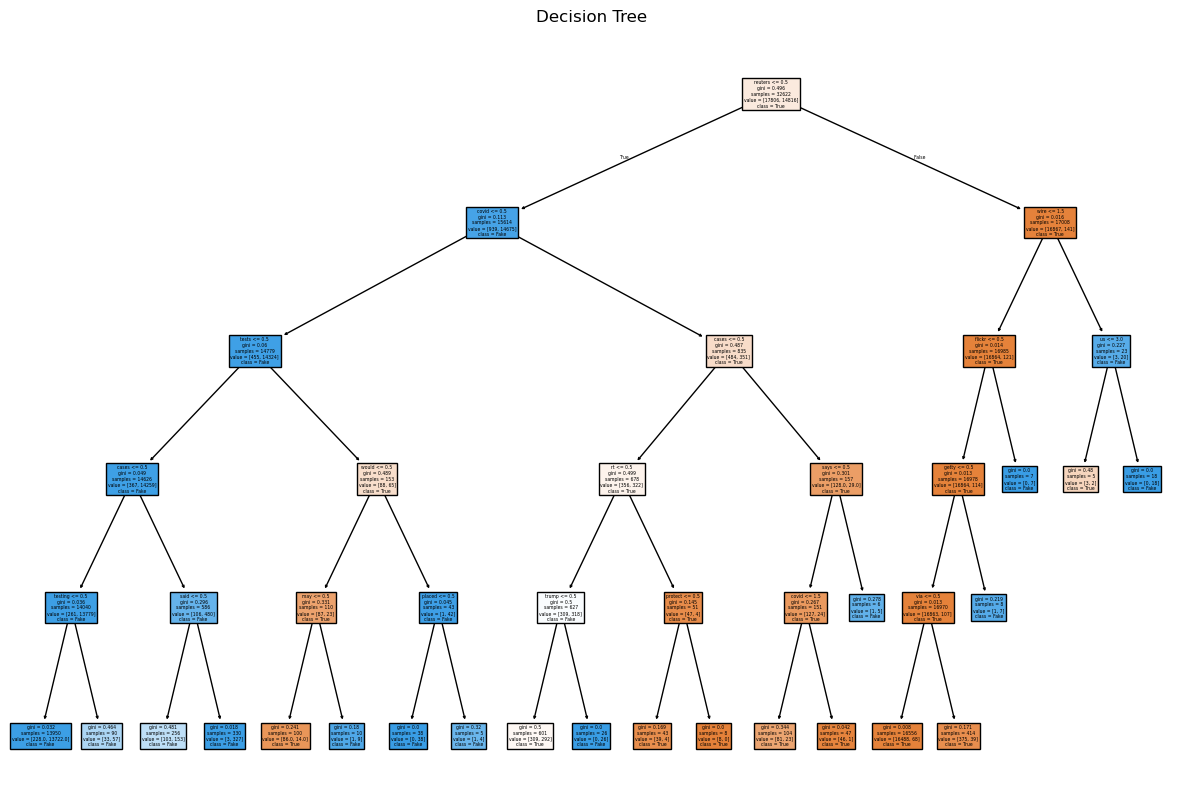

In [31]:
plt.figure(figsize=(15, 10))
plot_tree(DTmodel, feature_names=vectorizer.get_feature_names_out(), class_names=['True', 'Fake'], filled=True)
plt.title("Decision Tree")
plt.show()

# Train the Random Forest Classifier Model

In [32]:
RFCmodel =   RandomForestClassifier(
     n_estimators=200,          # Increase the number of decision tree
    max_depth=15,              # limit depth to reduce overfitting
    min_samples_split=5,       # node mus thave 5 sample to split
    min_samples_leaf=4,        
    max_features='sqrt',       # square root to balance accuracy and efficiency
    bootstrap=True,            # Ensure bootstrap sampling to reduce overfitting and improve generilization
    random_state=42     
)
RF_cv_scores = perform_cross_validation(RFCmodel, X, y, "Random Forest Classifier")


Cross-validation results for Random Forest Classifier:
Individual fold scores: [0.85679255 0.99901913 0.97535557 0.90079706 0.80257511]
Mean CV Score: 0.907 (+/- 0.146)


In [33]:
RFCmodel.fit(X_train, y_train)


RandomForestClassifier(max_depth=15, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [34]:
pred_RFC = RFCmodel.predict(X_test)
RFCmodel.score(X_test, y_test)

0.9675085826385483

# Evaluate the model

In [35]:
# Predictions
y_pred = RFCmodel.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
report = classification_report(y_test, y_pred, target_names=['Fake', 'True'])
print(report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig = ff.create_annotated_heatmap(z=cm, x=['Fake', 'True'], y=['Fake', 'True'], 
                                  colorscale='Viridis', 
                                  showscale=True)
fig.update_layout(title='Confusion Matrix')
fig.show()

Accuracy: 0.97
              precision    recall  f1-score   support

        Fake       0.97      0.97      0.97      4504
        True       0.96      0.97      0.96      3652

    accuracy                           0.97      8156
   macro avg       0.97      0.97      0.97      8156
weighted avg       0.97      0.97      0.97      8156



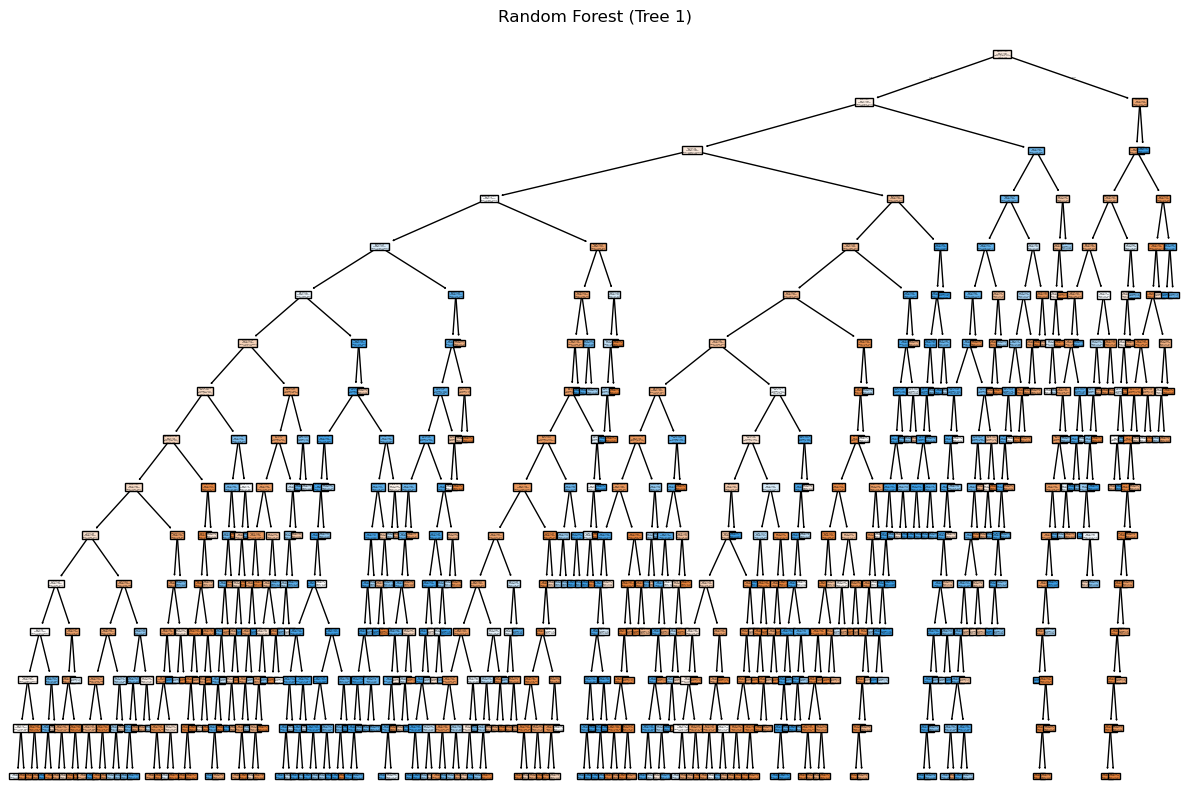

In [36]:
# Visualize a single tree from the Random Forest
plt.figure(figsize=(15, 10))
plot_tree(RFCmodel.estimators_[0], feature_names=vectorizer.get_feature_names_out(), class_names=['True', 'Fake'], filled=True)
plt.title("Random Forest (Tree 1)")
plt.show()

In [37]:
y_pred_rf = RFCmodel.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)


In [38]:
accuracies = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [lr_accuracy, dt_accuracy, rf_accuracy]
})

In [39]:
# Plot Accuracy Comparison
fig = px.bar(accuracies, x='Model', y='Accuracy', title='Model Comparison: Accuracy')
fig.show()

# ROC curve comparision


In [40]:
lr_fpr, lr_tpr, lr_auc = calculate_roc_with_cv(model, X, y)
dt_fpr, dt_tpr, dt_auc = calculate_roc_with_cv(DTmodel, X, y)
rf_fpr, rf_tpr, rf_auc = calculate_roc_with_cv(RFCmodel, X, y)

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=lr_fpr, y=lr_tpr, mode='lines', name=f'Logistic Regression (AUC={lr_auc:.2f})'))
fig.add_trace(go.Scatter(x=dt_fpr, y=dt_tpr, mode='lines', name=f'Decision Tree (AUC={dt_auc:.2f})'))
fig.add_trace(go.Scatter(x=rf_fpr, y=rf_tpr, mode='lines', name=f'Random Forest (AUC={rf_auc:.2f})'))
fig.update_layout(title='ROC Curve Comparison', xaxis_title='False Positive Rate', yaxis_title='True Positive Rate')
fig.show()

In [42]:
def predict_news(input_text):
    cleaned_input = preprocess_text(input_text)  # Clean the input text
    vectorized_input = vectorizer.transform([cleaned_input]).toarray()  # Transform using the vectorizer
    
    # Predictions using all three models
    lr_prediction = model.predict(vectorized_input)
    dt_prediction = DTmodel.predict(vectorized_input)
    rf_prediction = RFCmodel.predict(vectorized_input)
    
    # Output the predictions
    print(f"Input News: {input_text}")
    print(f"Logistic Regression Prediction: {'Fake' if lr_prediction[0] == 1 else 'True'}")
    print(f"Decision Tree Prediction: {'Fake' if dt_prediction[0] == 1 else 'True'}")
    print(f"Random Forest Prediction: {'Fake' if rf_prediction[0] == 1 else 'True'}")

# News Input

In [43]:
user_input = "Trump is not the precident"

In [44]:
predict_news(user_input)

Input News: Trump is not the precident
Logistic Regression Prediction: Fake
Decision Tree Prediction: Fake
Random Forest Prediction: Fake
